# Dynamical Neuroscience in Ukraine Academy: Day 6
# Real data with Python
Twitter: @mmyros

__Content creator:__ Maxym Myroshnychenko 

__Content reviewer:__ Anneke Duin

__Data ownership:__ UCL Cortexlab data.cortexlab.net

In [1]:
# @title Helper functions
# Install packages
# Warning:the following two commands will not work on windows. use pip install but without exclamation mark >/dev/null
!pip install -q -U hvplot bokeh
!pip install -q matplotlib pandas xarray numpy tqdm spykes
import os

import pandas as pd
import xarray as xr
import requests
from pathlib import Path
import zipfile


def download_data():
    print('Downloading data... Please wait. Should take less than 1 min')
    # Get link:
    r = requests.get('http://data.cortexlab.net/singlePhase3/data/dataset.zip')
    path = Path('data/dataset.zip')
    path.parent.mkdir(exist_ok=True)
    if not path.exists():
        with open(path, "wb") as fid:
            # Write out content of link:
            fid.write(r.content)
    # Unzip
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path.parent)


def load_spikes_from_phy(path_to_data='/Users/myroshnychenkm2/Downloads/dataset/', sampling_frequency=30000):
    """
    Get spikes from a kilosort/phy result folder
    :param path_to_data:
    :param sampling_frequency:
    :return:
    :id: neuron id, 1xN
    :ts: corresponding spiketime, 1xN
    """
    groupfname = os.path.join(path_to_data, 'cluster_groups.csv')
    groups = pd.read_csv(groupfname, delimiter='\t')

    # load spike times and cluster IDs
    with open(path_to_data + 'spike_clusters.npy', 'rb') as f:
        ids = np.load(f).flatten()
    with open(path_to_data + 'spike_times.npy', 'rb') as f:
        ts = np.load(f).flatten()

    # Create the list of our "good" labeled units
    ids_to_take = groups[(groups.group == 'good')].cluster_id
    # Find which spikes beloing to our "good" groups
    spikes_to_take = []
    for i in tqdm(ids_to_take, desc='Selecting only good spikes'):
        spikes_to_take.extend((ids == i).nonzero()[0])
    # only take spikes that are in our list
    ids = np.array(ids[spikes_to_take])
    ts = np.array(ts[spikes_to_take]).astype(float) / sampling_frequency

    return ids, ts


def bin_neuron(spike_times, bin_size=.100, window=None):
    """
    Make binned raster for a single neuron
    :param spike_times:
    :param bin_size: in sec
    :param window:
    :return:
    """
    if window is None:
        window = [0, spike_times.max()]
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    return np.histogram(spike_times, bins)[0]


def bin_neurons(spike_times, Neuron_IDs, bin_size=None, window=None, plotose=False):
    """
    Make binned raster for many neurons
    :param spike_times:
    :param Neuron_IDs:
    :param bin_size: in sec
    :param window:
    :param plotose:
    :return:
    """
    if window is None:
        window = [0, spike_times.max()]
    # the following uses an list comprehension for loop (look it up):
    spike_counts = [bin_neuron(spike_times[Neuron_IDs == Neuron_ID], bin_size, window)
                    for Neuron_ID in tqdm(np.unique(Neuron_IDs))]
    spike_counts = np.vstack(spike_counts)
    raster = xr.DataArray(spike_counts, coords=dict(Time=np.arange(window[0], window[1] + bin_size, bin_size)[:-1],
                                                    Neuron_ID=range(len(np.unique(Neuron_IDs)))),
                          dims=['Neuron_ID', 'Time'])
    if plotose:
        raster.plot(robust=True)
    return raster


def identify_events(ts, bin_size=.05, number_of_neurons_treshold=20, minimum_time_between_states=0.15):
    """
    Find spontaneous periods of quiecence in spiketimes
    :param ts:
    :param bin_size:
    :param number_of_neurons_treshold:
    :param minimum_time_between_states:
    :return:
    """
    lfp = bin_neuron(np.sort(ts), bin_size=bin_size)
    down_states = np.where(lfp < number_of_neurons_treshold)[0]
    down_states_lengths = np.diff(down_states)
    print(f'Eliminating {down_states[1:][down_states_lengths < .15 / bin_size].shape} that are too short')
    down_states = down_states[1:][down_states_lengths > minimum_time_between_states / bin_size]
    print(f'Ended up with {down_states.shape} events')
    # convert into seconds:
    down_states = down_states * bin_size
    down_states -= .03
    print(down_states[(down_states > 63) & (down_states < 68)])  # compare with raster
    return lfp, down_states


class PETH:
    """
    A collection of functions dealing with peristimulus time histogram
    """

    @staticmethod
    def events(trial_starts):
        """
        Simple wrapper creating a dataframe with times we want to lock onto
        :param trial_starts: List of times of interest (trials)
        :return: spykes object
        """
        return pd.DataFrame({'trialStart': trial_starts})

    @staticmethod
    def spykes_get_times(s_ts, s_id, debug=False):
        """
        Use spykes library
        :param s_ts:
        :param s_id:
        :param debug:
        :return:
        """

        def print_spyke(spykess):
            [print(len(spykess[i].spiketimes)) for i in range(len(spykess))]

        from spykes.plot import neurovis
        s_id = s_id.astype('int')
        neuron_list = list()
        for iu in np.unique(s_id):
            spike_times = s_ts[s_id == iu]
            if len(spike_times) < 2:
                if debug:
                    print('Too few spiketimes in this unit: ' + str(spike_times))
                else:
                    pass  # neuron_list.append(NeuroVis([],'ram'+str(iu)))
            else:
                neuron = neurovis.NeuroVis(spike_times, name='ram' + str(iu))
                neuron_list.append(neuron)

        if debug:
            print_spyke(neuron_list)
        return neuron_list

    @staticmethod
    def spykes_summary(spikes, events, event='trialStart', window=[-100, 100], bin_size=10, fr_thr=.1, plotose=True):
        """

        :param spikes:
        :param spykes_df:
        :param event:
        :param window:
        :param bin_size:
        :param fr_thr:
        :param plotose:
        :return:
        """
        import spykes
        assert window[1] - window[0] > 0, 'Window size must be greater than zero!'
        # filter firing rate
        spikes = [i for i in spikes if i.firingrate > fr_thr]
        pop = spykes.plot.popvis.PopVis(spikes)
        # calculate psth
        mean_psth = pop.get_all_psth(event=event, df=events, window=window, binsize=bin_size, plot=False)
        assert mean_psth['data'][0].size > 0, 'Empty group PSTH!'
        if plotose:
            # % plot heatmap of average psth
            _ = plt.figure(figsize=(10, 10))
            #        fig.subplots_adjust(hspace=.3)
            # set_trace()
            pop.plot_heat_map(mean_psth, sortby=None, sortorder='ascend', normalize=None,
                              colors=['viridis'])  # or latency

            # %% Population PSTH
            plt.figure()
            pop.plot_population_psth(all_psth=mean_psth, event_name='Event',
                                     colors=([.5, .5, .5], [0, .6, 0]))

        return pop, mean_psth


download_data()

In [2]:
# Import basic libraries
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

In [3]:
# @title Figure settings

%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
Neuron_IDs_huge, spike_times_all_neurons_huge = load_spikes_from_phy('data/')

Selecting only good spikes: 100%|██████████| 242/242 [00:03<00:00, 72.54it/s]


## Inspect variables

In [5]:
# Let's inspect the spikes
Neuron_IDs_huge

array([  13,   13,   13, ..., 1209, 1209, 1209], dtype=int32)

In [6]:
spike_times_all_neurons_huge

array([  10.07096667,   32.3822    ,   46.20356667, ..., 3773.10953333,
       3773.46326667, 3773.48606667])

**Questions**
* What are the numbers in the two blocks above?

### Exercise 1
What are the dimensions of each variable?

In [7]:
# TODO for students:
# Use the `X.shape` formalism to examine the shapes of each.

**Questions**

Is it possible to combine these two sets of numbers? How?

In [8]:
# Limit the number of spikes we're dealing with but keep full variables
Neuron_IDs = Neuron_IDs_huge[spike_times_all_neurons_huge < 70]
spike_times_all_neurons = spike_times_all_neurons_huge[spike_times_all_neurons_huge < 70]

Let's inspect the first ten timestamps from one neuron

In [9]:
# TODO for students:
# Complete the following code to print out the first ten timestamps from neuron 300
id_of_interest = Neuron_IDs[300]
spike_times_of_interest = spike_times_all_neurons[Neuron_IDs == id_of_interest]

## Visualize neurons' spike times

### Exercise 2
Inspect the timestamps from one neuron

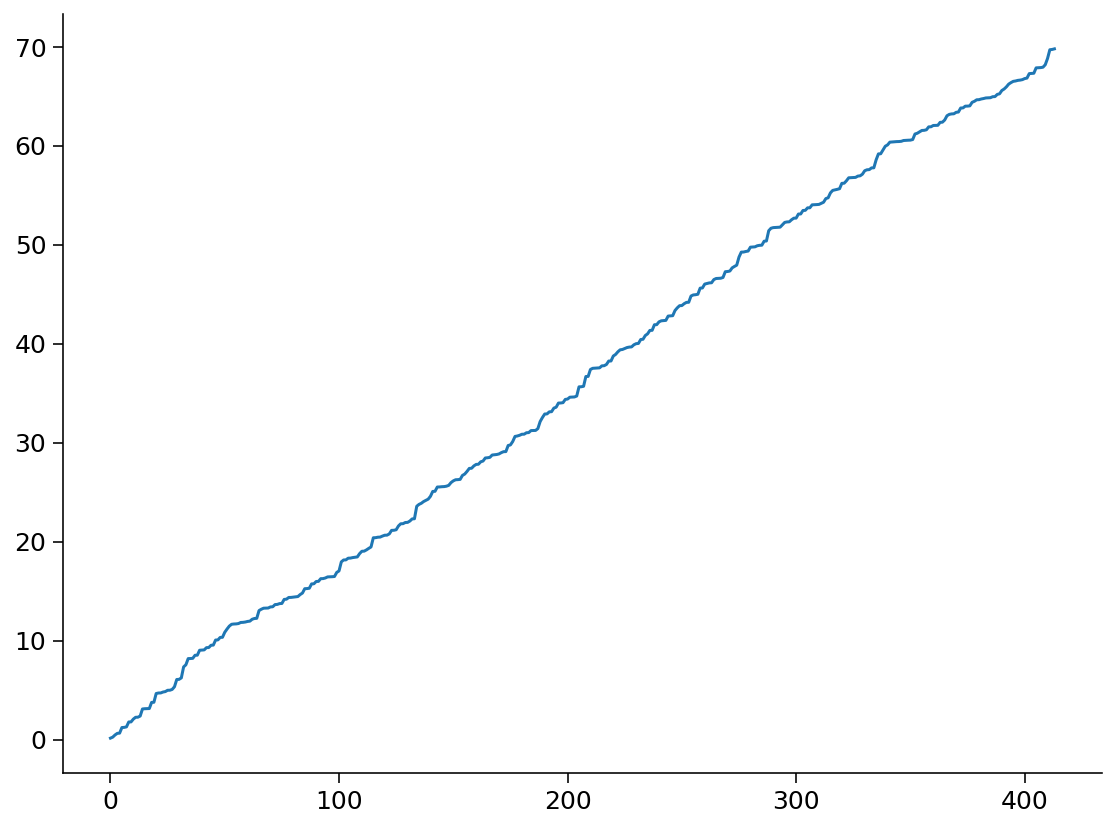

In [10]:
# Plot spiketimes
plt.plot(spike_times_of_interest);

**Questions**
1. What are neurons' identities in this plot?
2. Why is the curve progressively rising?
3. What's on the x- and y- axes?



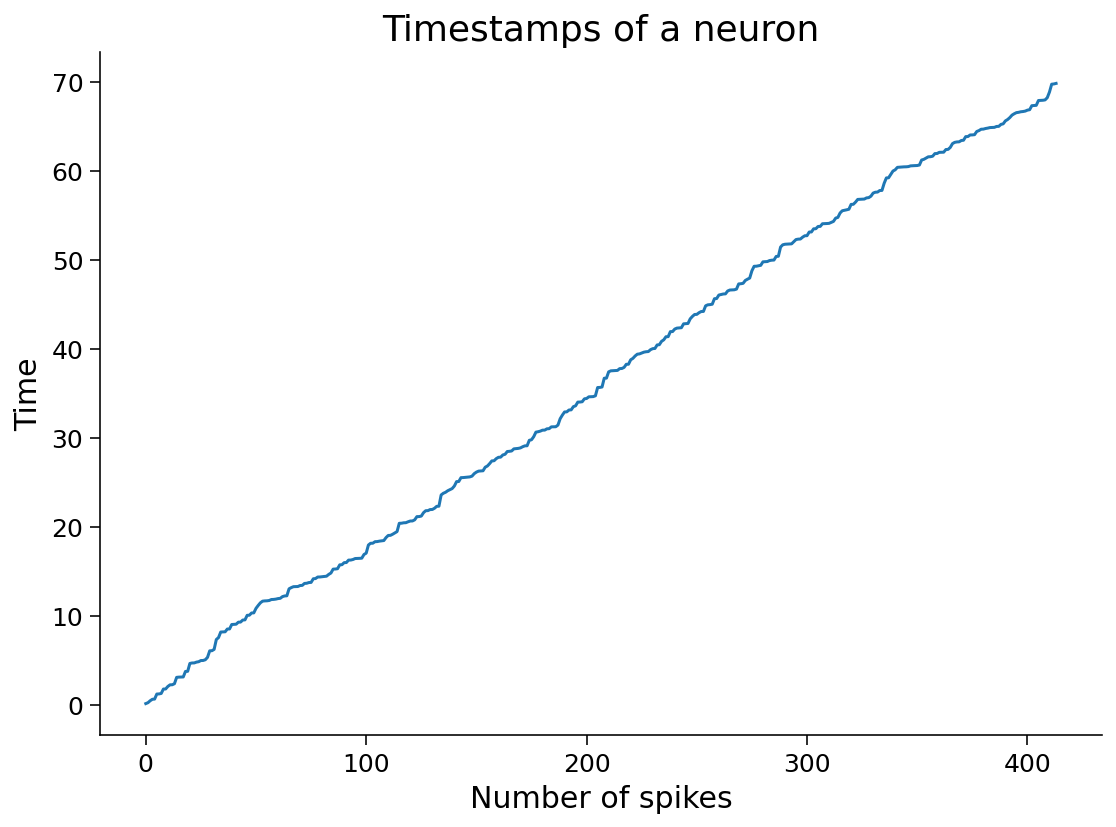

In [11]:
plt.plot(spike_times_of_interest)
plt.title('Timestamps of a neuron')
plt.ylabel('Time')
plt.xlabel('Number of spikes');

 What is a plot like this good for? (Hint: what would the change in firing rate look like?)

### Exercise 3
Visualize a neuron's spike times using a For loop

**Suggestions**
* Loop over time stamps of action potentials
* At each time stamp
   * Make a vertical tick at that value of time on the x axis
   * What should the y axis be?

In [12]:
## TODO for students:
# Uncomment below to get started


# Raster of one neuron, by hand
# for timestamp in spike_times_of_interest:
#     plt.scatter(x=..., y=..., marker='|', color='black')

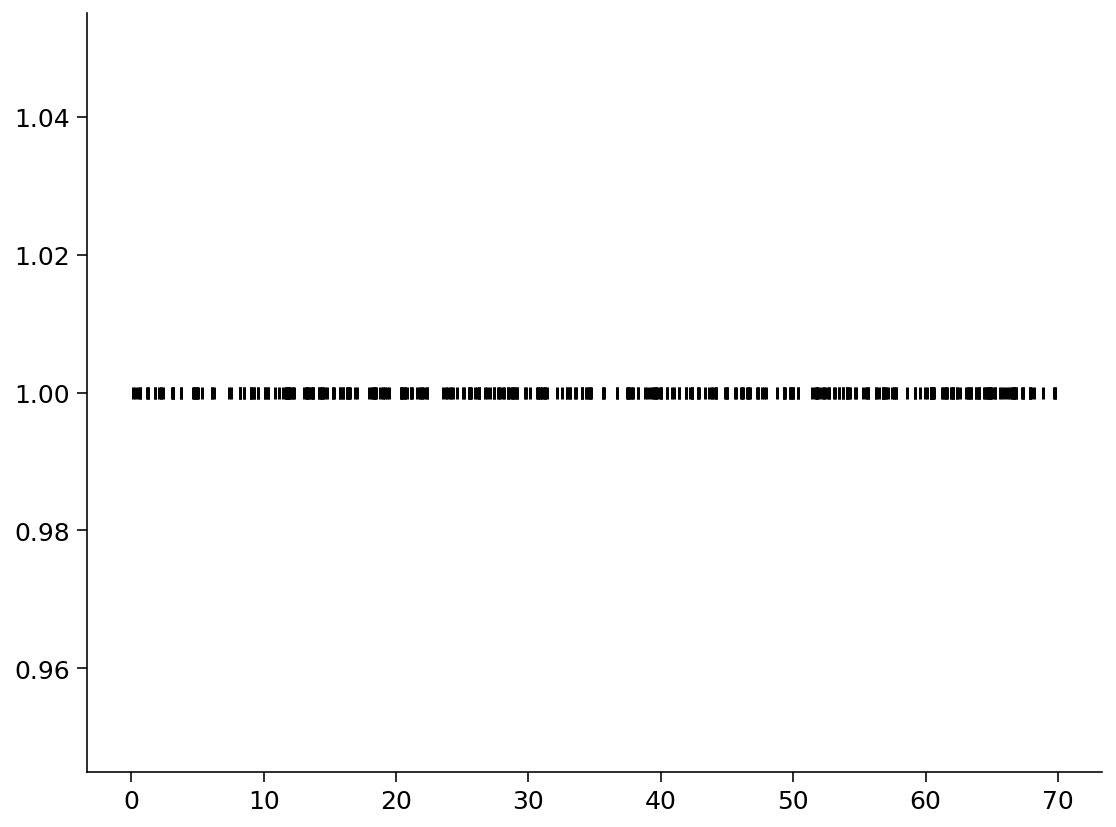

In [13]:
# to_remove solution

# Raster of one neuron, by hand
for timestamp in spike_times_of_interest:
    plt.scatter(x=timestamp, y=1, marker='|', color='black')

### Exercise 4
Visualize a neuron's spike times without a for loop

In [14]:
## TODO for students:
# Uncomment below to get started

# Whole raster for one neuron, no loop
# plt.scatter(x=...,
#             y=np.ones(spike_times_of_interest.shape...),
#             marker='|', color='black');

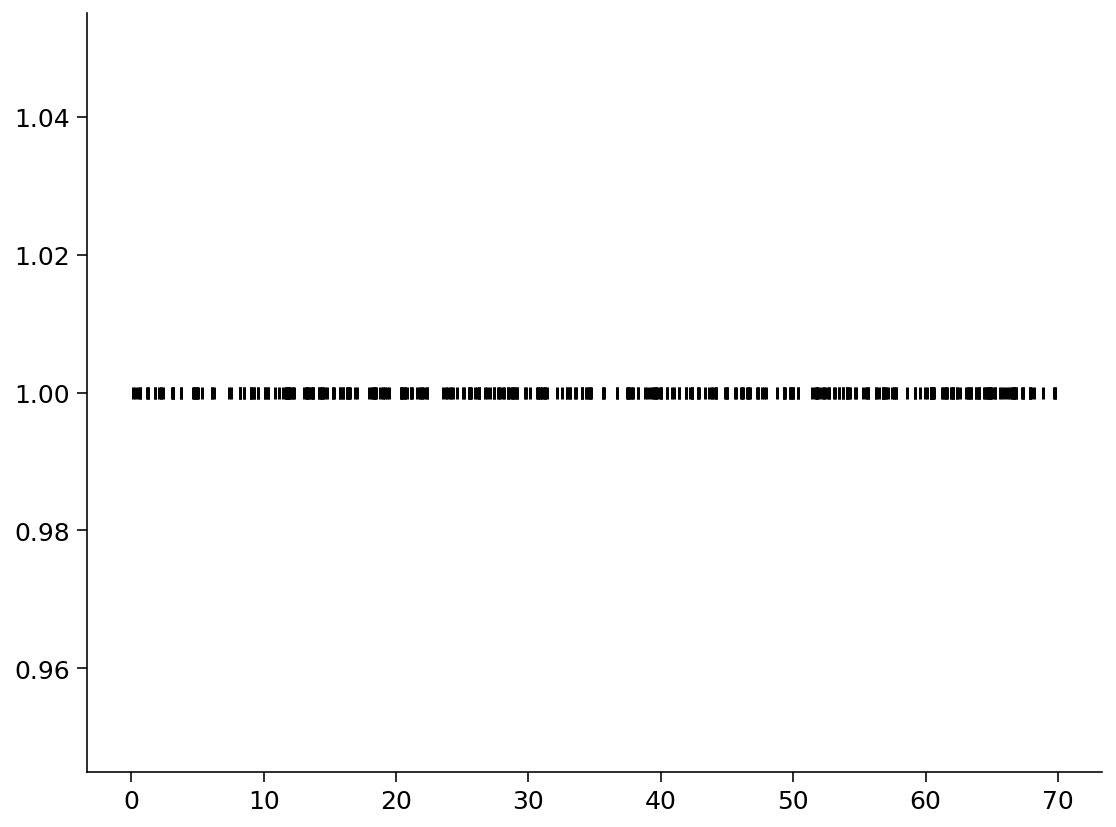

In [15]:
# to_remove solution
# Whole raster for one neuron, no loop
plt.scatter(x=spike_times_of_interest,
            y=np.ones(spike_times_of_interest.shape[0]),
            marker='|', color='black');

### Exercise 4

In [16]:
## TODO for students:
# Uncomment below to get started

# For all neurons now
# plt.scatter(x=...,
#             y=...,
#             marker='|', color='black', alpha=.7);

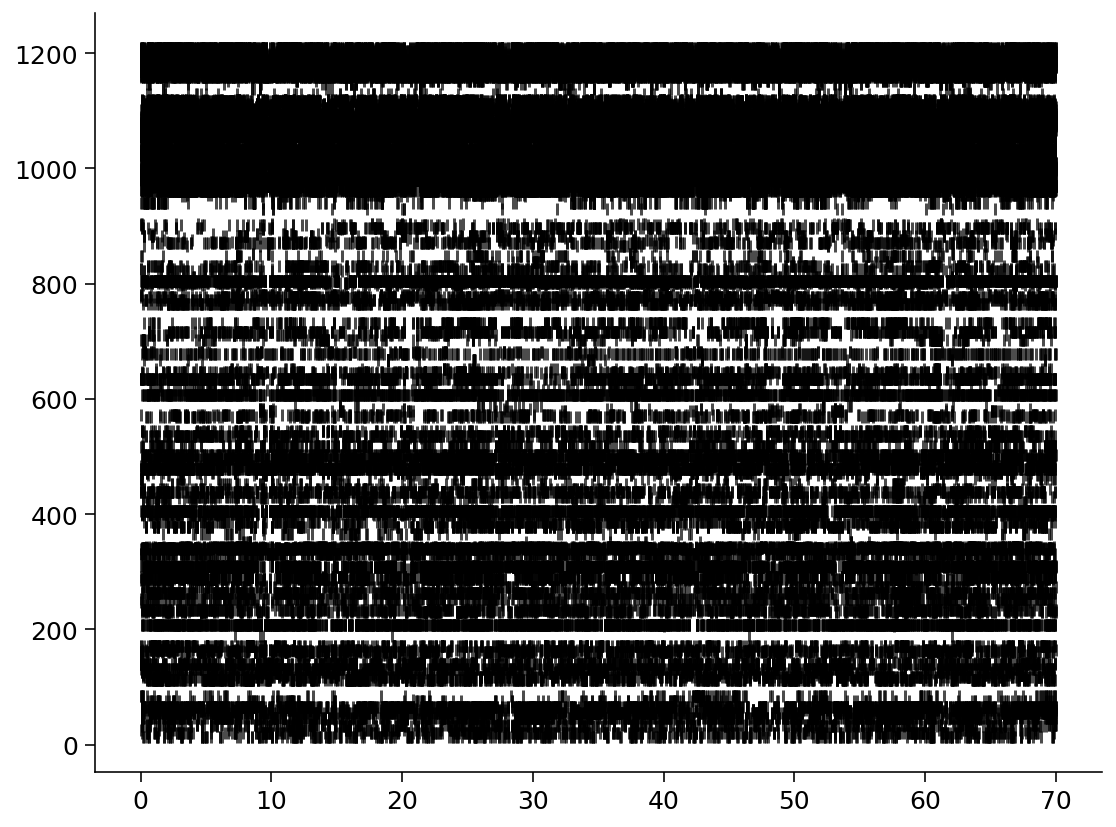

In [17]:
# to_remove solution
# For all neurons now
plt.scatter(x=spike_times_all_neurons,
            y=Neuron_IDs,
            marker='|', color='black', alpha=.7);

## Visualize binned raster of spikes

### Exercise 5
In this exercise, we will plot spikes using a histogram with 2 dimensions, time and neurons.
In other words, we will count how many times each neuron spiked in each time period, also known as bin.
Let's start by setting the bin to 5 milliseconds.

We will call such a histogram a _raster_

In [18]:
# Bin neurons
raster = bin_neurons(spike_times_all_neurons, Neuron_IDs, bin_size=.05)
raster

100%|██████████| 238/238 [00:00<00:00, 4863.25it/s]


<xarray.DataArray (Neuron_ID: 238, Time: 1400)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [2, 0, 1, ..., 0, 0, 0],
       [2, 0, 1, ..., 1, 1, 2],
       [0, 1, 2, ..., 0, 0, 0]])
Coordinates:
  * Time       (Time) float64 0.0 0.05 0.1 0.15 0.2 ... 69.8 69.85 69.9 69.95
  * Neuron_ID  (Neuron_ID) int64 0 1 2 3 4 5 6 7 ... 231 232 233 234 235 236 237

**Questions**
1. What are the names of the two dimensions of the variable `raster`? (Hint: you'll need these names below)
2. What do the values of raster hold?
  * Hint: A look at the values might help: Use `raster.values`
3 What numbers are representative of the raster's values? Is one more prevalent than all others?
  * Hint: you can use the command `np.unique(raster.values)` to check
**Extra credit**
1. On what parameter of data processing does the maximal number `raster` depend?
2. Make a graphical representation of `raster`'s distribution with bins and counts as axes

In [19]:
## TODO for students:
# Uncomment below to get started

# For x and y below, use the names of dimensions of the variable `raster`.

# raster.plot(x='...',
#             y='...',
#             robust=True);

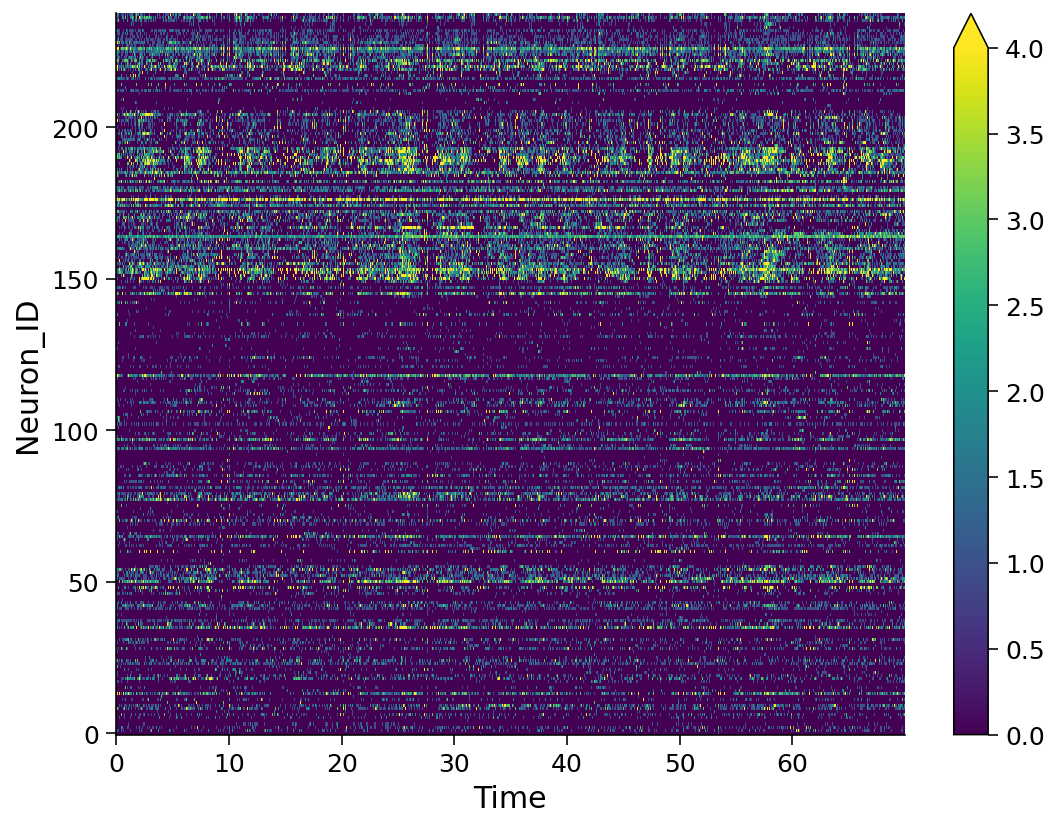

In [20]:
# to_remove solution
raster.plot(x='Time',
            y='Neuron_ID',
            robust=True);

### Exercise 6
Interactive version including the whole dataset

In [21]:
## TODO for students:
# Uncomment below to plot interactive full dataset. Zoom in on areas of the raster that catch your eye


# import holoviews as hv
# import hvplot.xarray # noqa
# hv.extension('bokeh')
# raster_huge = bin_neurons(spike_times_all_neurons_huge, Neuron_IDs_huge, bin_size=.12)

# raster_huge.hvplot(x='Time', y='Neuron_ID', clim=(0,12)).opts(cmap='viridis')

### Exercise 7
Slice dataset to save interesting times/neurons

Note: Your solution will most likely look different from mine. We are just looking for area of the
raster with striking features.

In [22]:

## TODO for students:
# Uncomment below to get started

# raster.sel(...=slice(..., ...),
#            ...=slice(..., ...)
#           ).plot(robust=True);

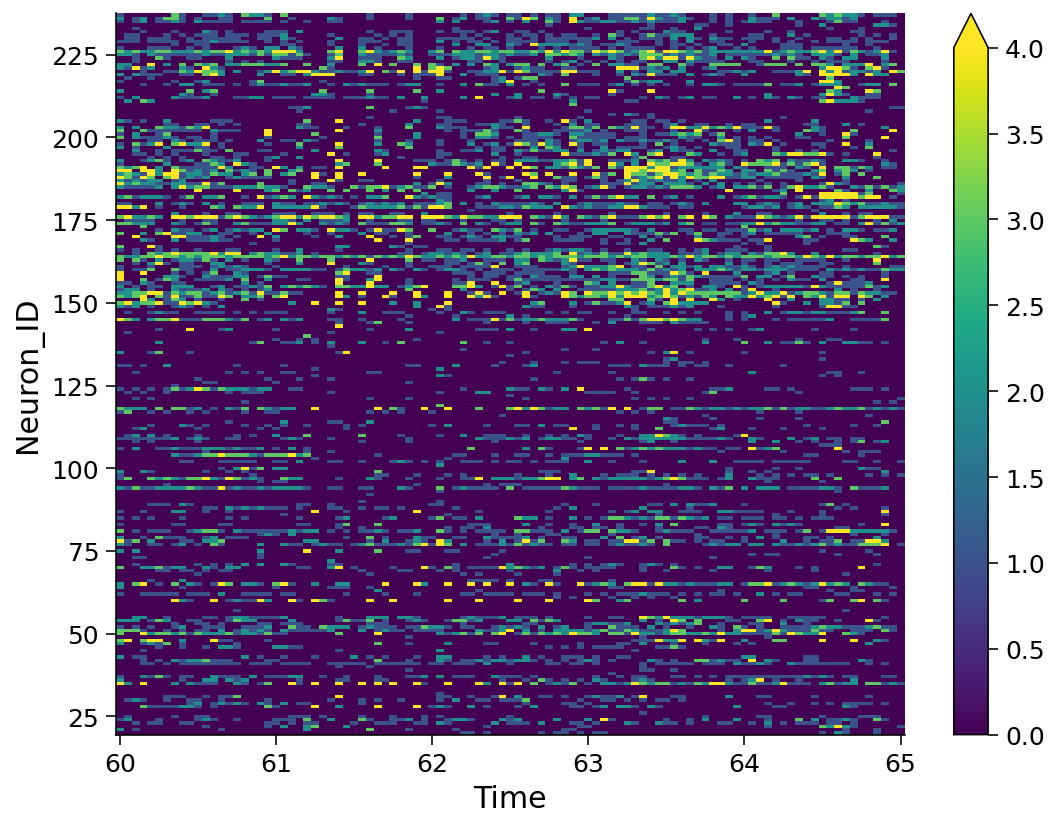

In [23]:
# to_remove solution
raster.sel(Neuron_ID=slice(20, 1200),
           Time=slice(60, 65)
           ).plot(robust=True);

## Visualize event-related raster

### Exercise 8

This dataset includes some behavior. However, at this point we don't know what behavior is happening and when.
Can you think of a way to zero in on some features of spikes you found earlier?


**Suggested steps**:
   * Make a function that returns raster 1/4 second before and 1/4 second after a certain event.

We will call such an event-related raster a _perievent time histogram_ (PETH)

In [24]:
multiunit_activity, event_times = identify_events(spike_times_all_neurons_huge)

# make raster with bin=10ms
raster = bin_neurons(spike_times_all_neurons_huge, Neuron_IDs_huge, bin_size=.01)
# Select one neuron
raster241 = raster.sel(Neuron_ID=241)

  0%|          | 0/242 [00:00<?, ?it/s]

Eliminating (9,) that are too short
Ended up with (142,) events
[]


100%|██████████| 242/242 [00:08<00:00, 29.16it/s]


**Suggestions**
   1. Complete the function `half_a_second()`
      * It should select a slice of 1/4 second before an event and 1/4 second after
   2. Use `half_a_second()` to create a perievent time histogram (PETH)

**Questions**
   * What do you think the events were? Take a guess

In [25]:
## TODO for students:
# Uncomment below to get started
# def half_a_second(raster, timestamp):
#     return raster.sel(Time=slice(timestamp - ...,
#                                  timestamp + ...)).values[:50]
#
#
# psth = [half_a_second(raster241, ...) for ... in event_times]
# psth = np.vstack(psth)
#
# plt.pcolormesh(psth);

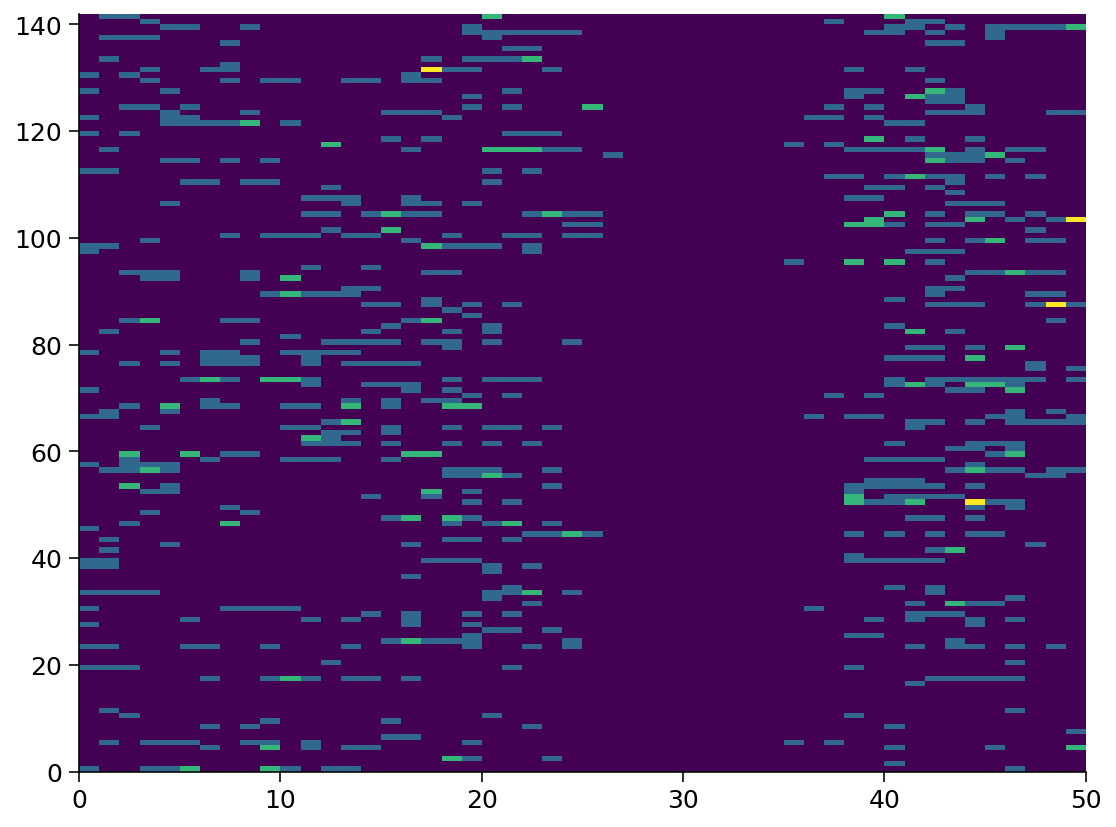

In [26]:
# to_remove solution
def half_a_second(raster, timestamp):
    return raster.sel(Time=slice(timestamp - .250,
                                 timestamp + .250)).values[:50]


peth = [half_a_second(raster241, timestamp) for timestamp in event_times]
p2th = np.vstack(peth)

plt.pcolormesh(peth);

### Exercise 8
PETH for all neurons

In [27]:
## TODO for students:
# Uncomment below to get started

# make a peth object using the provided Spykes toolbox:
events = PETH.events(event_times)

# make a list of spiketimes that our toolbox can understand:
spikes = PETH.spykes_get_times(spike_times_all_neurons_huge,
                               Neuron_IDs_huge)
# Get mean PSTH for all neurons
# raster_object, all_psth = PETH.spykes_summary(spikes=...,
#                                               events=...,
#                                               window=[-300, 400],
#                                               bin_size=5,
#                                               plotose=True)

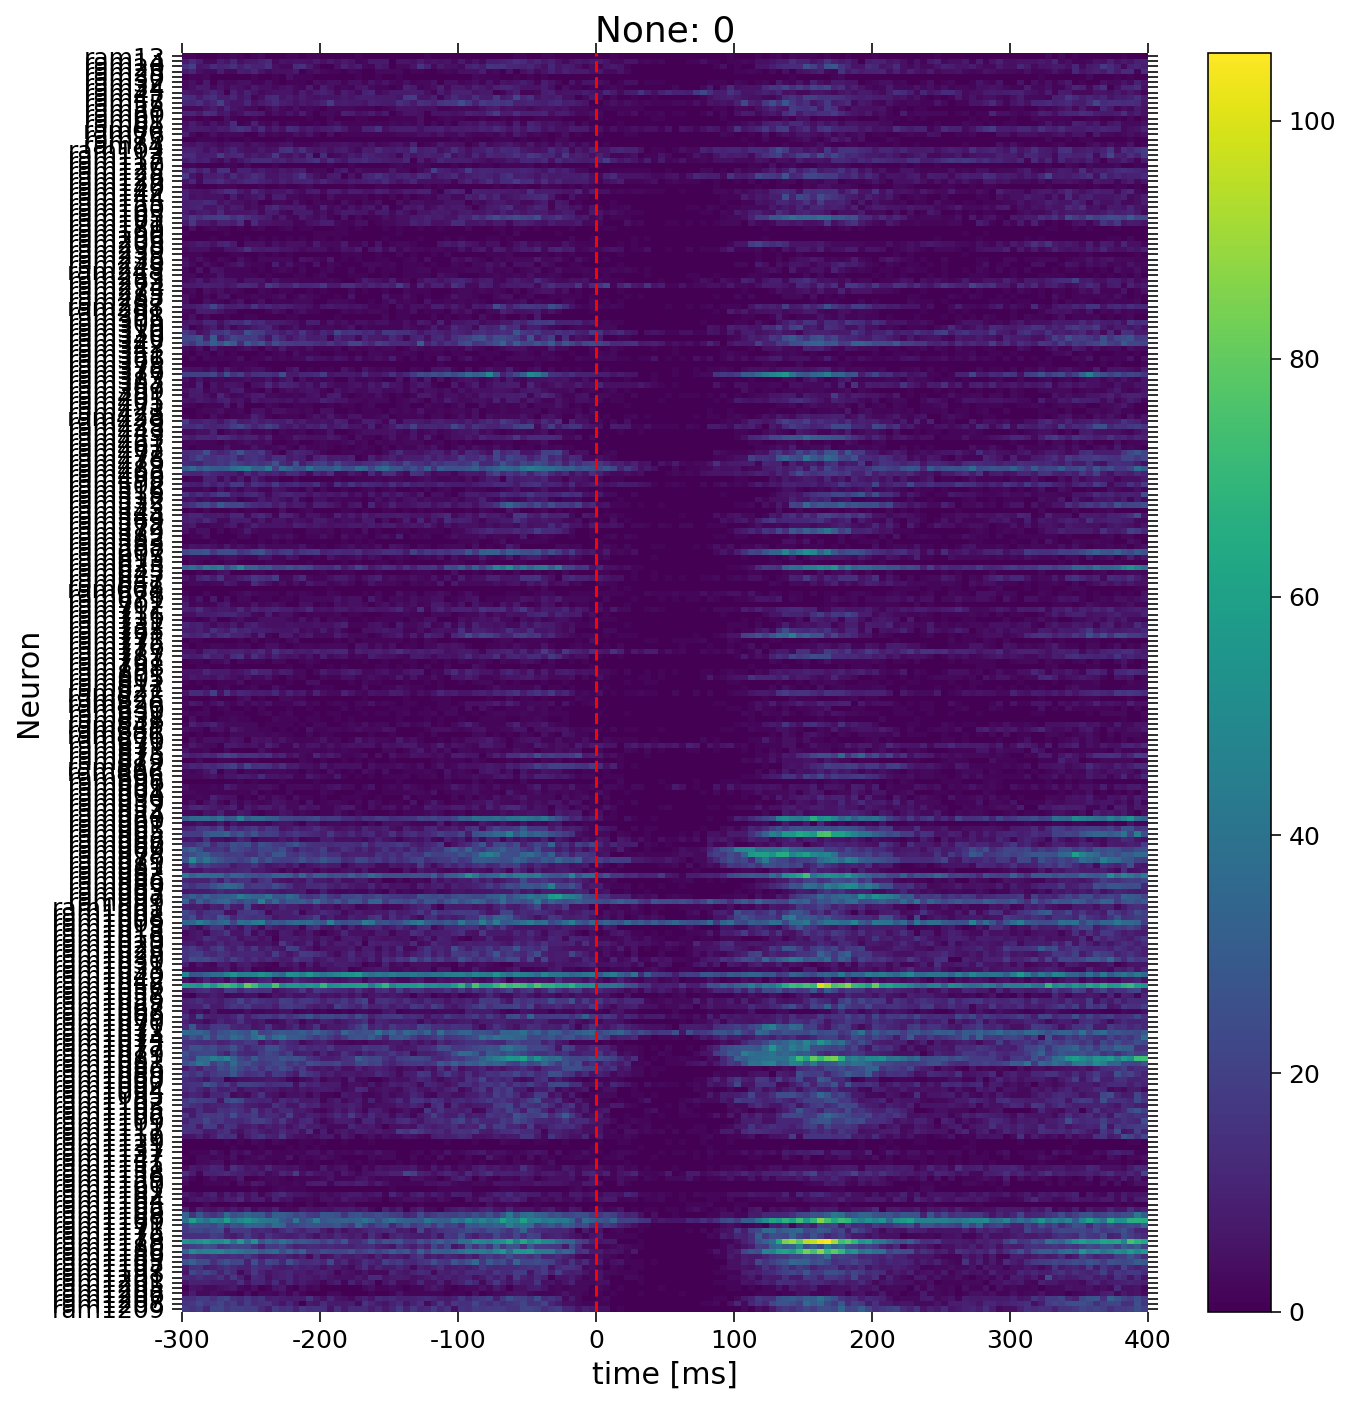

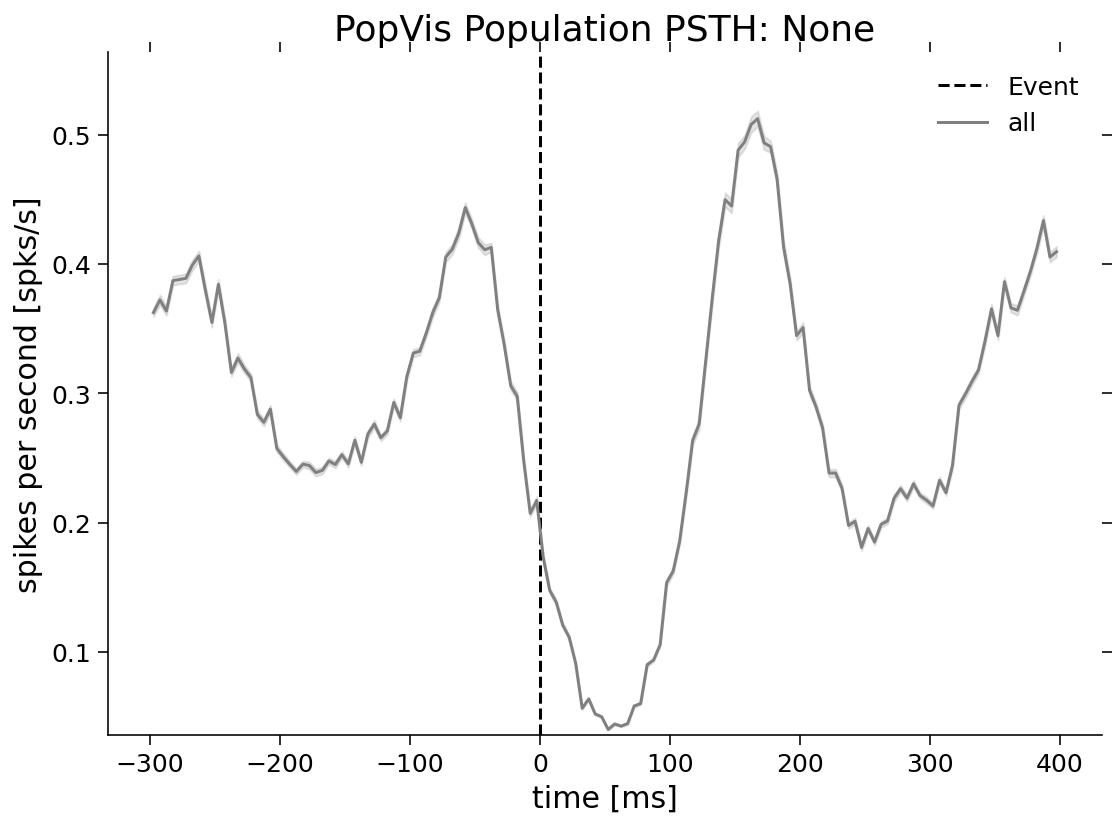

In [28]:
# to_remove solution

# make a peth object using the provided Spykes toolbox:
events = PETH.events(event_times)

# make a list of spiketimes that our toolbox can understand:
spikes = PETH.spykes_get_times(spike_times_all_neurons_huge,
                               Neuron_IDs_huge)
# Get mean PETH for all neurons
raster_object, all_psth = PETH.spykes_summary(spikes=spikes,
                                              events=events,
                                              window=[-300, 400],
                                              bin_size=5,
                                              plotose=True)

**Questions**
1. What are the axes in the resulting plots?
2. In your own words, what does the code above do?
3. Why does the curve rise up and down repeatedly?


**Extra credit**
- You don't see how PETH is actually coded up. How would you have done it? Describe in pseudo-code.
   - eg In a loop for each X, I would look for Y, then multiplied it thus making Z. Z would become my Y axis in the plot.



In [29]:
## TODO for students:
# Uncomment below to get started

# Make a 3d plot with mean PSTH for all neurons
# raster_object.plot_heat_map(all_psth, sortby='rate', sortorder='ascend', normalize=None, colors=['viridis'])  # or latency

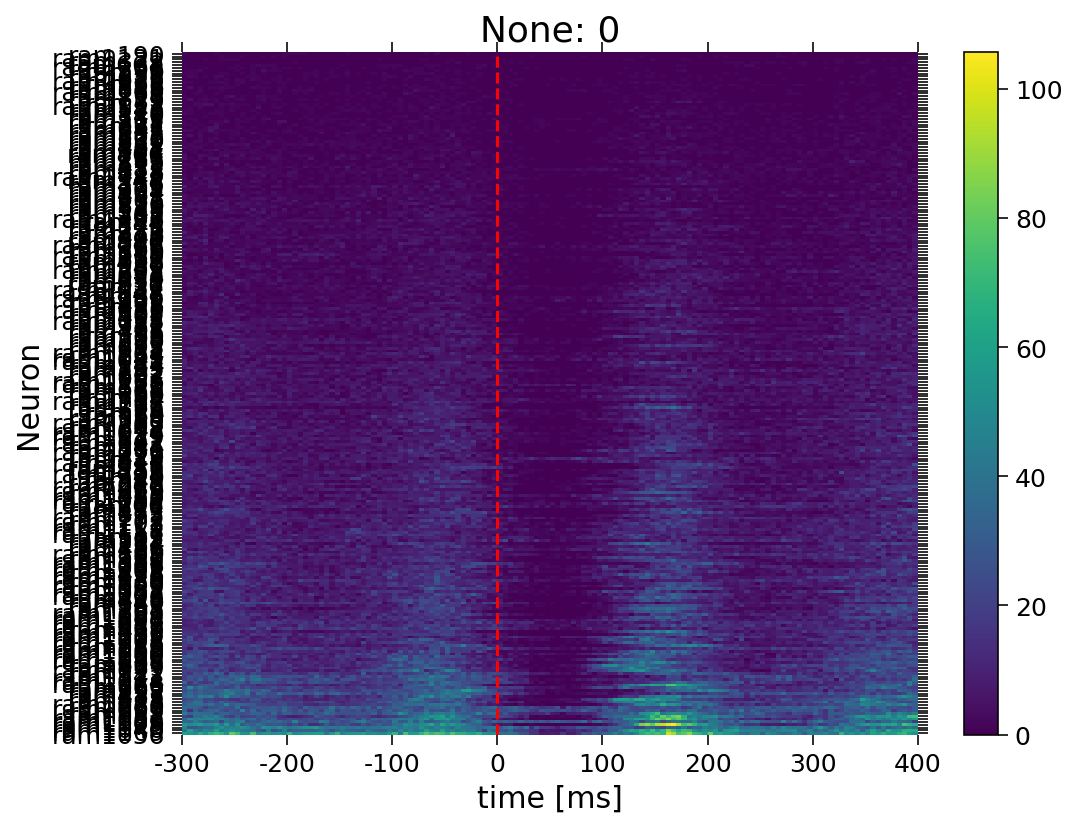

In [30]:
# to_remove solution

# Make a 3d plot with mean PSTH for all neurons
raster_object.plot_heat_map(all_psth, sortby='rate', sortorder='ascend', normalize=None, colors=['viridis'])  # or latency

**Questions**
1. How is this plot different from the previous two?
2. How is this achieved? Take a guess - what would you have done?

**Extra credit**
1. How do you think the gray curve will look if you invert the detection of events we explained in Exercise 8?
2. Test your hypothesis by setting `event_times = np.where(multiunit_activity > 90)[0]` and replotting

# Extra credit 1
Plot a neuron's ISI distribution
Review: What are interspike intervals (ISIs)? We covered this in lecture

In [31]:
id_of_interest = Neuron_IDs[241]
one_neuron_spike_times = spike_times_all_neurons[Neuron_IDs == id_of_interest]

one_raster=raster.sel(Neuron_ID=241)

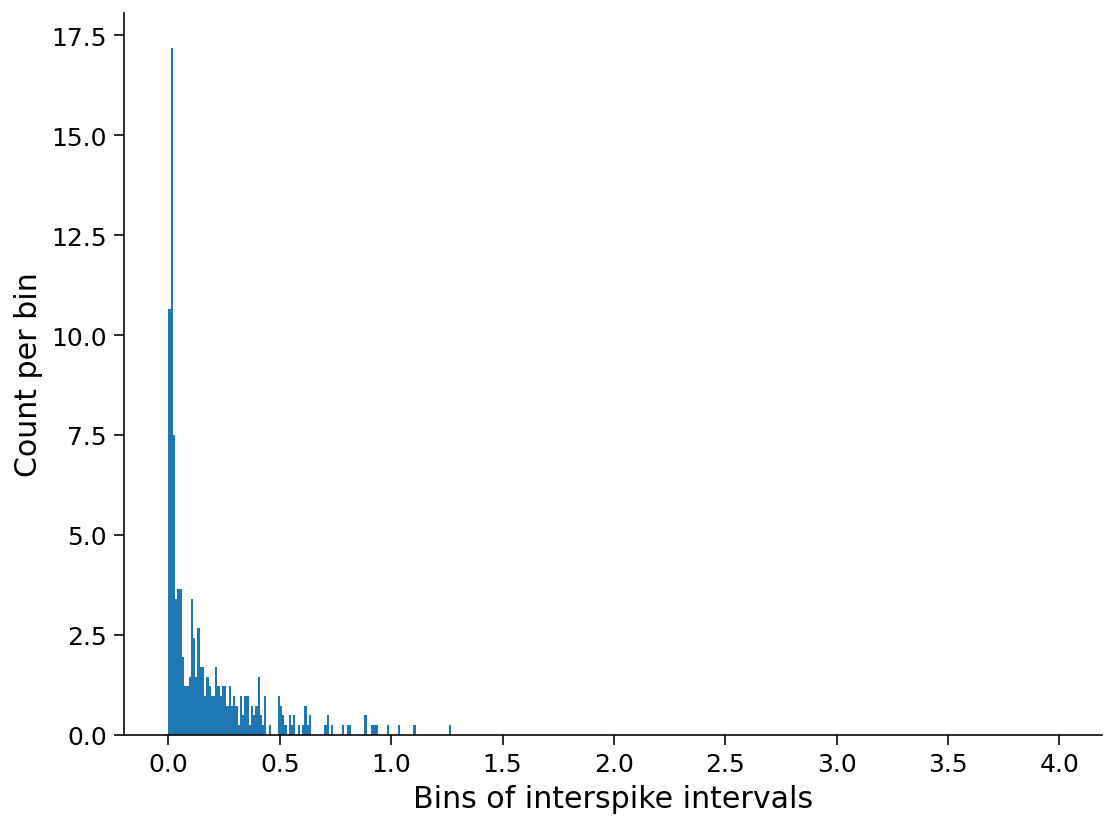

In [32]:
isis=np.diff(one_neuron_spike_times)
x=np.arange(0, 4, .01)

plt.hist(isis, bins=x, density=True)
plt.xlabel('Bins of interspike intervals')
plt.ylabel('Count per bin');

**Questions**
1. Are there more long intervals between spikes, or short ones?
2. During periods of high neuronal activity, should there be more long intervals, or short ones?

In [ ]:
# TODO for students:
# Find the mean of ISIs in this neuron

In [36]:
# to_remove solution
sum(isis)/len(isis)

0.16869878934624694

**Questions**
1. How does this describe our ISI distribution? How would the mean ISI change for a slower neuron?
A faster neuron?

# Extra credit 2
Fit a statistial model to reproduce a neuron's ISI distribution

Prerequisites: 
1. Understand the concept of distribution
1. Play with sliders at https://distribution-explorer.github.io/continuous/gamma.html#pdf-and-cdf-plots

Questions:
1. Look at the PDF plot (left). Does it resemble the ISI distribution at any slider positions? What are they?
1. What does changing gamma distribution's mean (alpha, a.k.a. shape) do?
1. What about its variance (beta, a.k.a. scale)?


In [33]:
# @title Maintenance
# Version for Colab:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz
# Version for Python on you own computer:
# !pip install numpyro jax jaxlib arviz scipy
from jax import random
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
import numpyro
import scipy.stats as stats

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numpyro 0.6.0 requires jax==0.2.10, but you have jax 0.2.13 which is incompatible.


ValueError: jaxlib is version 0.1.62, but this version of jax requires version 0.1.65.

In [ ]:
def model(isis):
    # Our initial broad guesses at scale and shape:
    scale = numpyro.sample('scale', dist.Gamma(1., 4))
    shape = numpyro.sample('shape', dist.Gamma(1., 4))
    # Provide obvserved data:
    numpyro.sample('obs', dist.Gamma(scale, shape), obs=isis)


# Try to reproduce ISIs by drawing some samples from our model.
# It will arrive at an estimate of scale and shape
mcmc = MCMC(NUTS(model), 1000, 2000)
mcmc.run(random.PRNGKey(0),isis)

# Convert to dataarray
data = az.from_numpyro(mcmc)
# Take a mean
best_guess=data.posterior.mean(['chain','draw'])

In [ ]:
best_guess

In [ ]:
isi_fit=stats.gamma.pdf(x=x,
                    a=best_guess['scale'],
                    scale=best_guess['shape'])

plt.plot(x, isi_fit)
plt.hist(isis, bins=x, density=True);